# Cox proportional hazard model

Voor mijn verdiepende model ga ik mijn verdiepen in het "Cox Proportional hazard model". Dit is een niet lineair regressie model. Het plan voor dit onderzoek is het toepassen van een al gemaakte library, op een door kaggle vekregen dataset die later tevoorschijn komt. Om het model en de achterliggende werking te begrijpen zal ik ook een poging doen om het model na te maken, en deze dan vergelijken met de eerder benoemde library.

## Achtergrond informatie

Dit model valt onder een gebied is statistiek genaamd "Survival analysis". Deze hoek van statistiek houd zich bezich met het analyseren van resultaten die te maken hebben met een tijds-component (Deo et al., 2020). Bij outcome research wordt er vaak een hazard ratio bepaald doormiddel van het hazard model, deze wordt gebruikt om te bepalen of het onderzoek het gewilde effect gehad heeft.

Het Cox propertional hazard model (CPHM) is in 1972 bedacht door David Cox. Dit model kan gebruikt worden om het effect van meerdere continue en categorische variabelen op de survival te bepalen. Het kwantificeren van verschillen in survival verdelingen tussen groepen wordt gedaan door het berekenen van een hazard ratio. Deze ratio is de ratio van de trend van een gebeurtenis op elk mogelijk moment van 1 groep in verhouding tot de andere groep (Deo et al., 2021).

CPMH gebruikt de verschillende covariates (variabelen die mogelijk impact kunnen hebben op een event) samen met een bijbehorende coefficient (beta). Deze beta waarden representeren de log-hazard ratio van de bijbehorende covariate. Een positieve beta-value houd in dat de kans op het event (zoals bijvoorbeeld sterven) verhoogt. Een negatieve beta-value is dan ook geassocieerd met een lagere kans op het event. rond de 0 is geen verschil in kans. Als je een covariate age hebt met een beta-value van 0.2, houd in dat als age met 1 toeneemt er een 20% increase van de log-hazard van het event. Dit is in log scale, en kan lastig zijn om te interpreteren. Dit kan verbeterd worden door de beta value als een exponent voor e te nemen. Dit geeft de hazard ratio (HR). Een HR > 1 houd weer een increase van risk in. < 1 een decrease en rond de 1 blijft de risk gelijk.

## Data
Ik gebruik data van de R package genaamd "survival". De dataset gaat over longkanker en heb ik weggeschreven naar een csv bestand. Mijn plan is om langzaam de verschillende stappen van CPHM uit te werken op deze data. Met uitleg erbij over de stappen die gezet worden. Aller eerst moet er gekeken worden naar de data zelf. En mogelijk wat dingen veranderd worden. Deze dataverwerking ga ik uitvoeren met polars, deze library lijkt wat meer op R en is mijn voorkeur boven pandas.


In [112]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [113]:
df = pl.read_csv("lungcancer_survival.csv", has_header=True, null_values="NA")
df

inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
3,306,2,74,1,1,90,100,1175,null
3,455,2,68,1,0,90,90,1225,15
3,1010,1,56,1,0,90,90,null,15
5,210,2,57,1,1,90,60,1150,11
1,883,2,60,1,0,100,90,null,0
…,…,…,…,…,…,…,…,…,…
1,188,1,77,1,1,80,60,null,3
13,191,1,39,1,0,90,90,2350,-5
32,105,1,75,2,2,60,70,1025,5


De data is nu ingelezen. We zien een aantal vanzelfsprekende kolommen. Status is overleden of niet (1 en 2). Sex man:1 vrouw:2. Ik wil deze encodings graag omzetten naar 0 en 1 voor leesbaarheid.

De data bestaat uit 228 rijen, en 10 kolommen

In [114]:
df = df.with_columns(
    pl.col("status").replace([1,2], [0,1]),
    pl.col("sex").replace([1,2], [0,1])
)

df.head()

inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
3,306,1,74,0,1,90,100,1175,null
3,455,1,68,0,0,90,90,1225,15
3,1010,0,56,0,0,90,90,null,15
5,210,1,57,0,1,90,60,1150,11
1,883,1,60,0,0,100,90,null,0


Ook is er zichtbaar dat er verschillende NA waarden zijn. Ik wil graag bepalen hoeveel dit er zijn zodat ik kan bepalen of ik deze wil verwijderen, of imputeren.

In [115]:
sum(df.describe().row(1)[1:])

67.0

Hieruit blijkt het dat er 67 rijen zijn met een NA waarde. Omdat ik aardig krap zit met tijd voor deze opdracht besluit ik om deze eerst te verwijderen. Als er tijd oveblijft zal ik gaan kijken naar data imputatie.

In [116]:
df_nulless = df.drop_nulls()
df_nulless

inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
3,455,1,68,0,0,90,90,1225,15
5,210,1,57,0,1,90,60,1150,11
12,1022,0,74,0,1,50,80,513,0
7,310,1,68,1,2,70,60,384,10
11,361,1,71,1,2,60,80,538,1
…,…,…,…,…,…,…,…,…,…
11,203,0,71,1,1,80,90,1025,0
13,191,0,39,0,0,90,90,2350,-5
32,105,0,75,1,2,60,70,1025,5


Nu de data inprincipe schoon gemaakt is, kan ik weer verdiepen op survival analyses en het CPHM. Om eerst wat meer begrip te krijgen van survival analyses wil ik gaan kijken naar de Kaplan Meier curve. Deze curve geeft weer wat de survival probability is over tijd. Hiervoor moet de data wat aangepast worden. Zo zetten we de survival time, uniek op volgorde. Hoeveel mensen nog leven en hoeveel mensen dood zijn op dat tijd punt. Daarmee kan er een survival-value berekend worden.

In [117]:
df_kaplan = (df_nulless
 .select("time")
 .unique()
 .sort("time")
)
n_total = len(df_nulless)
unique_times = df_kaplan["time"].to_list()
at_risk_list = []
n_events_ = []
for time in unique_times:
    events_before_t = df_nulless.filter(pl.col("time") < time).height
    at_risk_at_t = n_total - events_before_t
    at_risk_list.append(at_risk_at_t)

    at_time_t = df_nulless.filter(pl.col("time") == time)
    n_events = at_time_t.filter(pl.col("status") == 1).height
    n_events_.append(n_events)

In [118]:
df_kaplan = df_kaplan.with_columns(
    pl.Series("at_risk", at_risk_list),
    pl.Series("n_events", n_events_),

)

df_kaplan = df_kaplan.with_columns(
    survival = (pl.col("at_risk") - pl.col("n_events")) / n_total
)




Deze df bevat de informatie nodig om een kaplan curve te maken! Deze curve werkt door de tijd te doen op de x-as en de survial property op y-as.

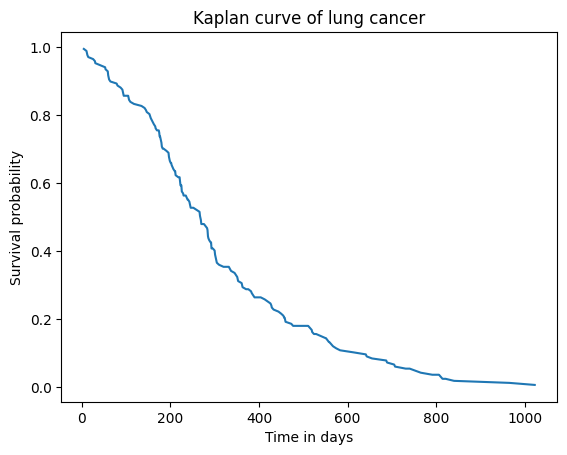

In [120]:
sns.lineplot(df_kaplan, x = "time", y = "survival")
plt.title("Kaplan curve of lung cancer")
plt.xlabel("Time in days")
plt.ylabel("Survival probability")
plt.show();

Deze plot geeft weer wat de kans van overleven is op een bepaald moment in dagen. Zo is  er zichtbaar dat bij dag 0 er een ~100% op overleven is, maar dat deze snel afneemt. Rond de 225 dagen zit deze kans al op 50%. En na 600 dagen zit deze al onder de 10%. Deze data kan gebruikt worden om de hazard te berekenen, ofwel de kans dat een patient dood gaat tussen 2 tijd punten. (TileStats, 2023)